In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
from six.moves import urllib

sns.set()

In [40]:
# nous alons utiliser les donnée titanic
titanic = sns.load_dataset('titanic') 

# suprimons tous les NaN
titanic.dropna(inplace=True)
titanic.describe() 

survived      pclass         age       sibsp       parch        fare
count  182.000000  182.000000  182.000000  182.000000  182.000000  182.000000
mean     0.675824    1.192308   35.623187    0.467033    0.478022   78.919735
std      0.469357    0.516411   15.671615    0.645007    0.755869   76.490774
min      0.000000    1.000000    0.920000    0.000000    0.000000    0.000000
25%      0.000000    1.000000   24.000000    0.000000    0.000000   29.700000
50%      1.000000    1.000000   36.000000    0.000000    0.000000   57.000000
75%      1.000000    1.000000   47.750000    1.000000    1.000000   90.000000
max      1.000000    3.000000   80.000000    3.000000    4.000000  512.329200

In [147]:
# séparation des donnée en trainig set et testing set
xtrain, xtest = train_test_split(titanic, train_size=0.8)
ytrain = xtrain.pop('survived')
ytest = xtest.pop('survived')

titanic.head()  

survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
1          1       1  female  38.0      1      0  71.2833        C  First   
3          1       1  female  35.0      1      0  53.1000        S  First   
6          0       1    male  54.0      0      0  51.8625        S  First   
10         1       3  female   4.0      1      1  16.7000        S  Third   
11         1       1  female  58.0      0      0  26.5500        S  First   

      who  adult_male deck  embark_town alive  alone  
1   woman       False    C    Cherbourg   yes  False  
3   woman       False    C  Southampton   yes  False  
6     man        True    E  Southampton    no   True  
10  child       False    G  Southampton   yes  False  
11  woman       False    C  Southampton   yes   True

In [54]:
# déterminons la tranche d'age des passagés
xtrain.age.hist()

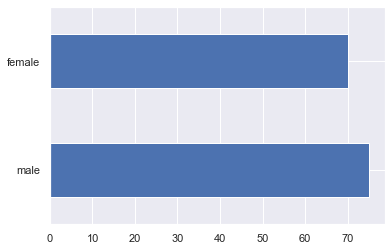

In [56]:
# déterminons le nombre de femme et d'homme
xtrain.sex.value_counts().plot(kind='barh')

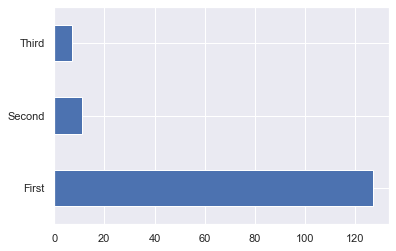

In [57]:
# déterminons le nombre de passager par class
xtrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

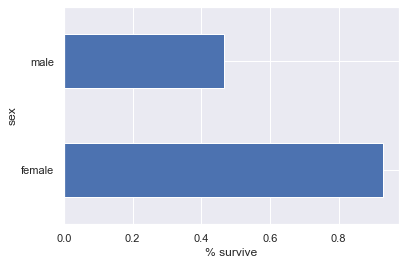

In [58]:
# déterminons le % d'homme et de femme eyant survécue
pd.concat([xtrain, ytrain], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [93]:
# feature columns
# liste des colones de chaines
STRING_COLUMNS = ['pclass','sex', 'sibsp', 'embarked', 'who', 'deck',
                       'embark_town','alive']
NUMERIC_COLUMNS = ['age', 'fare']

BOOLEAN_COLUMNS = ['adult_mal', 'alone']

feature_columns = []

for feature_name in STRING_COLUMNS:
  vocabulary = xtrain[feature_name].unique()  # récupére la liste de toutes les valeurs unique de chaque colonne
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

#for feature_name in BOOLEAN_COLUMNS:
#  feature_columns.append(tf.feature_column.indicator_column(feature_name))

print(feature_columns)

[VocabularyListCategoricalColumn(key='pclass', vocabulary_list=(1, 2, 3), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='sibsp', vocabulary_list=(1, 0, 2, 3), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embarked', vocabulary_list=('C', 'S', 'Q'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='who', vocabulary_list=('man', 'woman', 'child'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('C', 'B', 'D', 'E', 'F', 'A', 'G'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Cherbourg', 'Southampton', 'Queenstown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyList

In [117]:
#training process

# input function

def make_input_fn(data_df, label_df, num_epochs, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use


In [118]:
# We create a linear estimtor by passing the feature columns we created earlier
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\NOUNDO~1\\AppData\\Local\\Temp\\tmp9u4srz7v', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


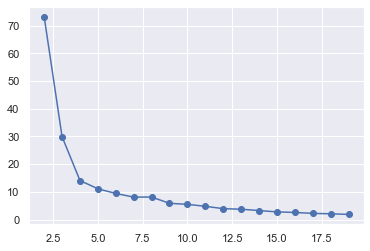

In [112]:
# find the num_epochs optimal
errors = []
for num_epoch in range(2,20):
    train_input_fn = make_input_fn(xtrain, ytrain,num_epochs=num_epoch) 
    test_input_fn = make_input_fn(xtest, ytest, num_epochs=1, shuffle=False) 
    
    linear_est.train(train_input_fn)  # train
    result = linear_est.evaluate(test_input_fn)  # get model metrics/stats by testing on tetsing data

    clear_output()  # clears consoke output
    
    errors.append(100*result['average_loss'])
plt.plot(range(2,20), errors, 'o-')
plt.show()

In [119]:
# on remarque que plus le epochs est grand, moins notre model fais d'érreur

# pour la suite nous allons utiliser la valeur 12 pour ne pas rendre notre modél sur entrainer
train_input_fn = make_input_fn(xtrain, ytrain, num_epochs=10)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
test_input_fn = make_input_fn(xtest, ytest, num_epochs=1, shuffle=False)


In [120]:

linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(test_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result)  # the result variable is simply a dict of stats about our model

{'accuracy': 0.9189189, 'accuracy_baseline': 0.6216216, 'auc': 0.98447204, 'auc_precision_recall': 0.9898428, 'average_loss': 0.25273556, 'label/mean': 0.6216216, 'loss': 0.22201094, 'precision': 0.88461536, 'prediction/mean': 0.73489296, 'recall': 1.0, 'global_step': 50}


INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\NOUNDO~1\AppData\Local\Temp\tmp9u4srz7v\model.ckpt-50
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


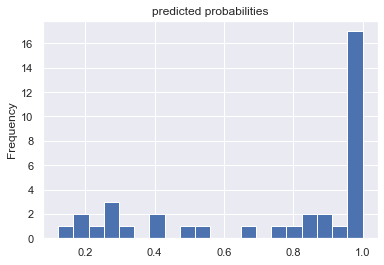

In [142]:
# liste des prédiction
pred_dicts = list(linear_est.predict(test_input_fn))

# déterminons la probabilité de chanse de survivre de chaque personne

probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')